### Purpose of this file ###
The file B2356run2.mat holds the transient info for the tire run that we care about. 

In this file, we try to synthesize the following : 
- Tire Temp versus Time
- $\mu (x)$ and $\mu (y)$ versus temp
- The value L (relaxation length -- distance traveled to hit 27.2% of steady-state lateral force output)

In [1]:
import numpy as np 
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
mat = loadmat('B2356run2.mat')
mat = {k:v for k, v in mat.items() if k not in {'__header__', '__version__', '__globals__', 'channel', 'source', 'testid', 'tireid'}}

# each column is of shape (58755, 1). Need to squeeze into 1D
mat = {k:v.squeeze() for k,v in mat.items()}
df = pd.DataFrame(mat)
# sort values in order of increasing time
df = df.sort_values(by='ET')
df.shape
df.head()

,AMBTMP,ET,FX,FY,FZ,IA,MX,MZ,N,NFX,...,RL,RST,RUN,SA,SL,SR,TSTC,TSTI,TSTO,V
0,25.55,0.16,2.10,-28.53,-662.39,-0.005,-5.48,0.98,0.03,-0.0032,...,19.54,26.97,2,-0.003,-0.0,-0.6365,26.25,26.29,27.29,0.01
1,25.55,0.17,3.05,-28.05,-665.15,0.013,-4.50,1.42,-0.04,-0.0046,...,19.53,27.00,2,-0.004,-0.0,-1.0932,26.25,26.30,27.25,0.03
2,25.57,0.18,1.83,-29.31,-661.93,0.001,-6.25,0.85,0.03,-0.0028,...,19.53,27.00,2,0.006,-0.0,-0.9547,26.23,26.35,27.25,0.04
3,25.56,0.19,1.83,-29.24,-661.79,-0.005,-6.04,0.82,0.09,-0.0028,...,19.54,27.02,2,0.002,-0.0,-0.7908,26.24,26.31,27.27,0.03
4,25.55,0.20,2.11,-30.81,-663.24,0.010,-6.20,1.06,0.03,-0.0032,...,19.53,27.04,2,0.006,-0.0,-0.9547,26.26,26.32,27.26,0.04


In [3]:
# Visualize tire info over time
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, filtfilt

# Setup noise ends with a spike in FZ graph. Add padding to avoid rest of spike
max_fz_time = df.loc[df['FZ'].idxmax(), 'ET'] + 5
df.drop(df.loc[df['ET'] <= max_fz_time].index, inplace=True)
df.head()

,AMBTMP,ET,FX,FY,FZ,IA,MX,MZ,N,NFX,...,RL,RST,RUN,SA,SL,SR,TSTC,TSTI,TSTO,V
1918,26.01,171.42,1.16,10.72,-235.37,-0.018,-2.99,-0.27,-0.04,-0.0049,...,19.99,28.83,2,0.000,-0.0,-1.1326,29.25,27.97,32.55,0.02
1919,25.99,171.43,2.55,11.13,-235.24,-0.003,-2.77,0.20,-0.04,-0.0108,...,19.99,28.80,2,-0.011,-0.0,-1.0746,29.29,27.97,32.55,0.04
1920,25.99,171.44,2.80,12.55,-235.95,-0.005,-2.14,0.34,0.03,-0.0119,...,19.98,28.78,2,-0.003,-0.0,-0.6282,29.27,28.00,32.55,0.01
1921,26.01,171.45,2.12,11.94,-233.08,-0.009,-3.08,0.13,0.03,-0.0091,...,19.99,28.76,2,0.003,-0.0,-0.9536,29.29,28.00,32.55,0.04
1922,26.00,171.46,2.55,11.24,-234.51,-0.009,-2.91,0.16,-0.04,-0.0109,...,19.99,28.73,2,-0.008,-0.0,-1.0954,29.33,27.99,32.56,0.03


### From observing the above data, we know the following :  ###

We test 3 tire pressures. For each tire pressure, we test 3 slip angles. For each pressure/angle combo, we test 3 normal loads.

In [4]:
# Visualize tire info over time
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os, shutil
folder = 'Plots/Raw_plots'

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

plt_per_row = 1
columns_to_plot = [col for col in df.columns if col != 'ET']

# n_plots = len(list(columns_to_plot)) * 3 #*3 JUST FOR FINDING RIGHT CUTOFF
# n_rows = int(np.ceil((n_plots) / plt_per_row))  # Arrange 3 plots per row
# df_size = df.shape[0]
# fig, axes = plt.subplots(n_rows, plt_per_row, figsize=(36, n_rows * 12))
# axes = axes.flatten()  # Flatten the axes array for easier indexing

# Butterworth cutoffs for each column
cutoffs = { # middle value is current best guess
    'AMBTMP' : [0.005],
    'FX' : [0.005],
    'FY' : [0.005],
    'FZ' : [0.005],
    'IA' : [0.005],
    'MX' : [0.005],
    'MZ' : [0.01],
    'N' : [0.005],
    'NFX' : [0.005],
    'NFY' : [0.01],
    'P' : [0.01],
    'RE' : [0.01],
    'RL' : [0.005],
    'RST' : [0.005],
    'RUN' : [0.00707],
    'SA' : [0.04], #Previously [.03, .05]
    'SL' : [0.005],
    'SR' : [0.005],
    'TSTC' : [0.00707],
    'TSTI' : [0.005],
    'TSTO' : [0.00707],
    'V' : [.04] #Previously .00707
}

# Filtering - Butterworth
def butter_lowpass_filter(data, cutoff=0.01, fs=1.0, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_df = df.apply(lambda col: butter_lowpass_filter(col, cutoffs[col.name][0]) if col.name not in ('ET', 'FZGrad') else col)

# Plot every column w.r.t ET
for i, col in enumerate(columns_to_plot):
    for j, cutoff in enumerate(cutoffs[col]):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 12))
        ax.set_title(f"ET vs {col} - v{j}")
        ax.set_xlabel('ET')
        ax.set_ylabel(col)
        
        # Plot raw data
        ax.plot(df['ET'], df[col], label="raw")

        # Plot filtered values
        ax.plot(df['ET'], filtered_df[col], label = "filtered")
        # Plot best-fit spline
        # spline = scipy.interpolate.make_splrep(df['ET'], df[col], s=df_size // 100)
        # l_bound, r_bound = df['ET'][0], df['ET'][df_size - 1]
        # num_pts = int(np.ceil((r_bound - l_bound))) * 100 # plot every 100th of a second
        # et_continuous = np.linspace(l_bound, r_bound, num_pts)
        # col_continuous = spline(et_continuous)
        # ax.plot(et_continuous, col_continuous, label="spline")

        plt.savefig(f'Plots/Raw_plots/ET vs {col}')
        plt.close()

# Find Boundaries of each test
Because each plot has 27 tests of unique pressure-slip angle-normal force settings

In [5]:
# Segment by test
FZGrads = np.gradient(filtered_df['FZ'], filtered_df['ET'])
max_grad = np.abs(FZGrads).max()
tgt_grad = max_grad / 5

print(max_grad, tgt_grad)

# threshold = 60
# indices = np.argwhere((FZGrads >= tgt_grad - threshold) & (FZGrads <= tgt_grad + threshold))[0]
# indices = np.argwhere(np.abs(FZGrads) >= tgt_grad).flatten()
# print(len(indices), len(filtered_df['ET']), indices.max(), indices.min())

# partitions = []
# start = indices[0]
# for i in range(1, len(indices), 1):
#     if indices[i] > indices[i - 1] + 20:
#         partitions.append(start)
#         partitions.append(indices[i - 1])
#         start = indices[i]
# partitions.append(start)
# partitions.append(indices[-1])

# ET_partitions = filtered_df['ET'].iloc[list(partitions)].values

# print(len(ET_partitions), ET_partitions)

indices = np.argwhere(np.abs(FZGrads) < tgt_grad).flatten()
partitions = []
start = indices[0]
for i in range(1, len(indices), 1):
    if indices[i] >= indices[i - 1] + 5:
        # avoid adding false-windows from pauses when we changed pressure
        # Windows must be at least 1s (100 data points) large
        if indices[i - 1] >= start + 100:
            partitions.append(start)
            partitions.append(indices[i - 1])
        start = indices[i]

ET_partitions = filtered_df['ET'].iloc[list(partitions)].values

print(len(ET_partitions), ET_partitions)


931.5988828202353 186.31977656404706
54 [171.42  186.37  188.73  208.4   210.72  230.22  232.91  252.39  254.79
 274.36  276.72  296.24  298.95  318.44  320.81  340.38  342.77  362.42
 381.84  401.46  403.8   423.42  425.8   445.26  447.91  467.37  469.71
 489.4   491.73  511.22  513.929 533.409 535.799 555.378 557.768 577.438
 596.847 616.487 618.827 638.406 640.806 660.286 662.956 682.475 684.805
 704.435 706.815 726.284 728.934 748.454 750.774 770.453 772.823 792.653]


# Construct Marked Plots
Superimpose test boundary markings on all plots

In [6]:
folder = 'Plots/Marked_plots'

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

for i, col in enumerate(columns_to_plot):
    # Plot lines on graph
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 12))
    ax.set_title(f"ET vs {col}")
    ax.set_xlabel('ET')
    ax.set_ylabel(col)

    # Plot raw data
    ax.plot(df['ET'], df[col], label="raw")

    # Plot filtered values
    ax.plot(df['ET'], filtered_df[col], label = "filtered")

    # Plot partitions
    for partition in ET_partitions:
        plt.axvline(x=partition, color='g', linestyle='-.', linewidth=1.5)

    plt.savefig(f'Plots/Marked_plots/ET vs {col}')
    plt.close()

# Partition by Test
Now that we have the time boundaries for each test, split into separate dataframes. 

In [7]:
tests = []
length = len(ET_partitions)

time_start = time_end = 0
for i in range(0, length, 2):
    time_start = ET_partitions[i]
    time_end = ET_partitions[i + 1]

    pd_raw = df[df['ET'].between(time_start, time_end)]
    pd_filtered = filtered_df[filtered_df['ET'].between(time_start, time_end)]
    tests.append((pd_raw, pd_filtered))

print(time_start, time_end)
print(tests[len(tests) - 1][0].head())
print(tests[len(tests) - 1][0].tail())

772.823 792.653
       AMBTMP       ET     FX    FY       FZ     IA    MX    MZ     N     NFX  \
56177   25.38  772.823 -22.39  1.32 -1108.25 -0.005 -7.85 -3.19  0.09  0.0202   
56178   25.39  772.833 -21.61  4.79 -1110.26 -0.002 -6.12 -2.70  0.03  0.0195   
56179   25.40  772.843 -22.04  6.15 -1110.13  0.006 -5.63 -2.68  0.09  0.0199   
56180   25.39  772.853 -21.36  7.59 -1112.27 -0.005 -4.54 -2.56 -0.04  0.0192   
56181   25.38  772.863 -22.59  7.55 -1111.08  0.003 -5.32 -3.02  0.16  0.0203   

       ...     RL    RST  RUN     SA   SL      SR   TSTC   TSTI   TSTO     V  
56177  ...  19.32  30.45    2  0.004 -0.0 -0.9978  28.98  27.86  29.27  3.19  
56178  ...  19.32  30.44    2 -0.004 -0.0 -0.9994  28.96  27.85  29.30  3.18  
56179  ...  19.32  30.44    2  0.006 -0.0 -0.9978  28.94  27.88  29.31  3.19  
56180  ...  19.33  30.44    2  0.002 -0.0 -1.0010  28.94  27.83  29.31  3.18  
56181  ...  19.32  30.45    2  0.003 -0.0 -0.9963  28.98  27.81  29.34  3.17  

[5 rows x 23 columns]


# Graph Split Tests, mark steady-state and target relaxation (63.2%) lateral force output, get start time of slip

Order of events : Get steady-state value -> get start time of slip -> get target value/time

In [15]:
from scipy.ndimage import gaussian_filter1d

folder = 'Plots/Partitioned'

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
# Stores (index of time associated with relaxation length, corresponding time value, dt) for test i in index i
time_bound_by_test = []

for i, test in enumerate(tests):

    curr_raw_df = test[0]
    curr_filtered_df = test[1]

    # -------------- GET MAX FY --------------
    max_FY_idx = np.argmax(np.abs(curr_filtered_df['FY']))
    # Still a little noisy because noise frequency is lower, so take average. **60 IS HYPERPARAMETER**
    max_FY = np.average(curr_filtered_df.iloc[max_FY_idx - 60:max_FY_idx+60]['FY'])
    

    # -------------- GET START TIME OF SLIP -- IGNORE JUMP AT THE START --------------

    FY_smooth = gaussian_filter1d(curr_raw_df['FY'], sigma=10)
    diff_smooth = np.diff(FY_smooth)
    diff_smooth = np.nan_to_num(diff_smooth, nan=0.0)
    # diff_smooth[catch_idx:] = 0
    
    drop_idx = np.where(np.abs(diff_smooth) >= .5 * np.max(np.abs(diff_smooth)))[0][0]
    
    start_slip_time = curr_raw_df.iloc[drop_idx]['ET']

    # -------------- FIND TARGET_FY IDX/VALUE --------------
    min_FY = curr_raw_df.iloc[drop_idx]['FY']
    target_FY = (max_FY - min_FY) * .632 + min_FY

    # Index that is the closest to target_FY
    # Use raw because filtered struggles with the transition from min to max
    deviation = np.abs(curr_raw_df["FY"] - target_FY)
    deviation[max_FY_idx:] = np.inf
    target_idx = np.argmin(deviation)
    target_time = curr_filtered_df.iloc[target_idx]['ET']
    time_bound_by_test.append((target_idx, target_time, target_time - start_slip_time))
    print(target_time - start_slip_time)

    # -------------- PLOTTING --------------
    # Plot lines on graph
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 12))
    ax.set_title(f"ET vs FY -- test {i}")
    ax.set_xlabel('ET')
    ax.set_ylabel("FY")

    # Plot raw data
    ax.plot(curr_raw_df['ET'], curr_raw_df["FY"], label="raw")

    # Plot filtered values
    ax.plot(curr_raw_df['ET'], FY_smooth, label = "filtered")
    
    plt.axhline(y=max_FY, color='g', linestyle='-.', linewidth=1.5)
    plt.axhline(y=target_FY, color='b', linestyle='-.', linewidth=1.5)

    # Plot point closest to target_FY
    plt.axvline(x=target_time, color='r', linestyle='-.', linewidth=1.5)
    plt.axvline(x=start_slip_time, color='g', linestyle='-.', linewidth=1.5)

    ax.plot()

    plt.savefig(f'{folder}/test {i}')
    plt.close()

0.18999999999999773
0.37000000000000455
0.6599999999999966
0.18000000000000682
0.3499999999999659
0.5400000000000205
0.1300000000000523
0.17000000000001592
0.22999999999996135
0.18999999999999773
0.46999999999997044
0.7300000000000182
0.18000000000000682
0.4199999999999591
0.6299999999999955
0.13999999999998636
0.18000000000006366
0.25
0.18999999999994088
0.35000000000002274
0.5399999999999636
0.15999999999996817
0.31999999999993634
0.4799999999999045
0.12000000000000455
0.17000000000007276
0.21000000000003638


# Obtain Relaxation lengths
Velocity said to be constant, just noisy, across ALL tests. Get average velocity and multiply by time to relaxation

3.1735389133627026


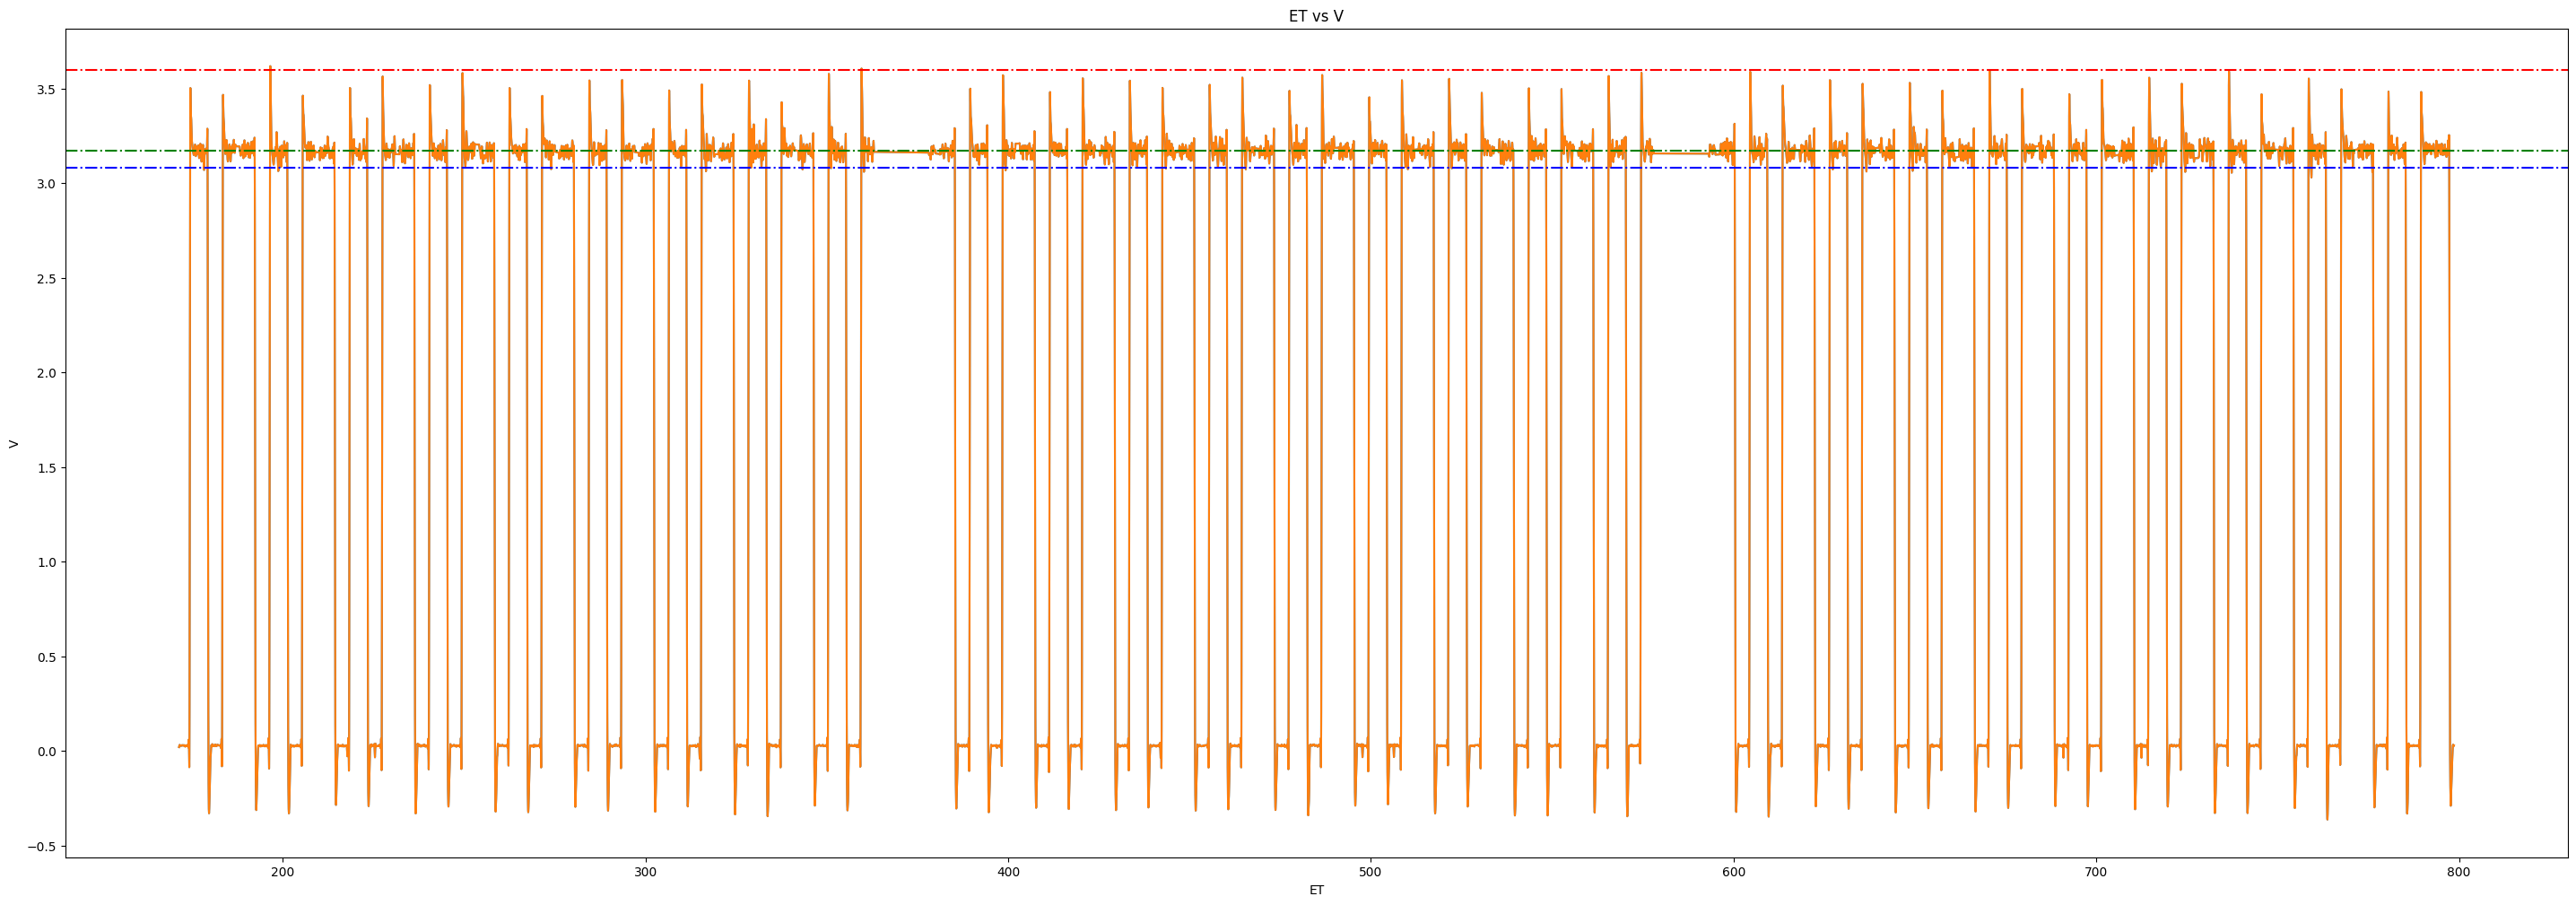

In [9]:
# Find Average Velocity -- Use raw because filtered struggles with the velocity sensor
from scipy.signal import find_peaks

# Get peak values
peaks, _ = find_peaks(df['V'], height=np.percentile(df['V'], 40))

# Ignore spikes
sorted_peaks = np.sort(df['V'].iloc[peaks].values)
# Extract middle values -- avoids peaks or non-noise dips
V_avg = np.mean(sorted_peaks[int(.2 * len(sorted_peaks)):int(.6 * len(sorted_peaks))])
print(V_avg)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 12))
ax.set_title(f"ET vs V")
ax.set_xlabel('ET')
ax.set_ylabel("V")

 # Plot raw data
ax.plot(df['ET'], filtered_df["V"], label="raw")

# Plot filtered values
ax.plot(df['ET'], filtered_df["V"], label = "filtered")

plt.axhline(y=sorted_peaks[0], color='b', linestyle='-.', linewidth=1.5)
plt.axhline(y=sorted_peaks[len(sorted_peaks) - 1], color='r', linestyle='-.', linewidth=1.5)
plt.axhline(y=V_avg, color='g', linestyle='-.', linewidth=1.5)
ax.plot()

plt.show()

# Compute Relaxation Lengths for each test

In [10]:

relaxation_lengths = []

for i, time_info in enumerate(time_bound_by_test):
    # V * dt
    print(time_info[0], time_info[1], time_info[2])
    # scale dt down by 3600 : sec -> hr
    relax_len = (time_info[2] / 3600) * V_avg * 1000
    relaxation_lengths.append(relax_len)
    print(relax_len)

309 174.51 0.10999999999998522
0.09696924457495842
799 196.72 0.2599999999999909
0.22920003263174274
829 219.01 0.539999999999992
0.47603083700439836
759 240.5 0.11000000000001364
0.0969692445749835
792 262.71 0.2799999999999727
0.24683080437263058
821 284.93 0.4700000000000273
0.4143231359112658
746 306.41 0.060000000000002274
0.05289231522271371
768 328.49 0.10000000000002274
0.08815385870453955
781 350.58 0.13999999999998636
0.12341540218631529
768 389.52 0.1099999999999568
0.09696924457493337
801 411.81 0.35000000000002274
0.30853850546583833
824 434.04 0.5600000000000023
0.4936616087453113
761 455.52 0.1099999999999568
0.09696924457493337
810 477.81 0.37000000000000455
0.3261692772067262
832 500.05 0.5799999999999841
0.5112923804861992
749 521.419 0.06999999999993634
0.06170770109310753
771 543.509 0.11000000000001364
0.0969692445749835
784 565.608 0.15999999999996817
0.14104617392720314
765 604.497 0.09999999999990905
0.08815385870443934
786 626.687 0.25
0.2203846467612988
807 64